In [ ]:
!nvidia-smi

In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import torch
print(torch.__version__)
torch.cuda.set_device(0)

1.13.0+cu117


In [4]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.version.cuda

'11.7'

In [3]:
import Models
import in_gp_modified as in_gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import my_utils

In [4]:
ts_data = np.loadtxt(open("ts_data.csv","rb"), delimiter=",")

In [5]:
print(ts_data.shape)

(106251, 36)


# 0. Preprocess data that can be fed into models

### Define input and output window length

In [8]:
input_dim = 30
output_dim = 5
T_span = input_dim + output_dim
n_id = 20

# 1. LSTM Prediction

### 1.0 Data Preparation for LSTM

In [9]:
# Differentiate X and y
np_X = ts_data[:,1:(input_dim+1)]
np_X = np_X.reshape((np_X.shape[0], np_X.shape[1], 1))
np_y_price = ts_data[:,input_dim:]
np_y_return = np.diff(np_y_price, axis=1)/np_y_price[:,:-1]

#Standardization
mu_X, std_X, np_X = my_utils.standardization(np_X)
mu_y, std_y, np_y = my_utils.standardization(np_y_return)


# Train Test Split With All Companies Included
X_i = np_X[np.where(ts_data[:,0]==0)]
y_i = np_y[np.where(ts_data[:,0]==0)]
np_X_train, np_X_test, np_y_train, np_y_test = train_test_split(X_i, y_i, test_size = 0.2, random_state = 42)
    
for i in range(1, n_id):
    X_i = np_X[np.where(ts_data[:,0]==i)]
    y_i = np_y[np.where(ts_data[:,0]==i)]
    np_X_train_i, np_X_test_i, np_y_train_i, np_y_test_i = train_test_split(X_i, y_i, test_size = 0.2, random_state = 42)

    np_X_train = np.concatenate((np_X_train, np_X_train_i), axis=0)
    np_X_test = np.concatenate((np_X_test, np_X_test_i), axis=0)
    np_y_train = np.concatenate((np_y_train, np_y_train_i), axis=0)
    np_y_test = np.concatenate((np_y_test, np_y_test_i), axis=0)


# Reshuffle Entire Datasets
idx = np.arange(np_X_train.shape[0])
np.random.shuffle(idx)
np_X_train, np_y_train = np_X_train[idx], np_y_train[idx]

idx = np.arange(np_X_test.shape[0])
np.random.shuffle(idx)
np_X_test, np_y_test = np_X_test[idx], np_y_test[idx]


# Convert to Torch Tensor 
X_train = torch.tensor(np_X_train)
X_test = torch.tensor(np_X_test)
y_train = torch.tensor(np_y_train)
y_test = torch.tensor(np_y_test)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([84990, 30, 1])
torch.Size([21261, 30, 1])
torch.Size([84990, 5])
torch.Size([21261, 5])


### 1.X Hyper-parameter Search

In [11]:
params_grids = {'hidden_size':[10, 20, 50, 100], 
                'num_layers':[2, 3, 4, 5], 
                'learningRate':[0.001, 0.002], 
                'num_iterations':[100, 200, 500, 1000]}
optimal_params = my_utils.LSTM_hyper_parameter_search(params_grids, output_dim, 
                                                      X_train, y_train, std_y, mu_y)

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /home/jupyter/YD/Optimization/Models.py

optimal_params: {'hidden_size': None, 'num_layers': None, 'learningRate': None, 'num_iterations': None}
max R2_val: 0.0


 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### 1.1 Train LSTM

In [42]:
LSTM = Models.LSTM(input_size=1, hidden_size=100, num_layers=5, output_size=output_dim, dropout=0)
LSTM.fit(X_train, y_train, learningRate=0.001, num_iterations=1000, batch_size=1000, weight_decay=0)

### 1.2 LSTM Prediction

In [43]:
y_train_pred_LSTM = LSTM.predict(X_train[:60000]).squeeze(-1)
y_test_pred_LSTM = LSTM.predict(X_test[:10000]).squeeze(-1)

y_train_pred_LSTM = y_train_pred_LSTM.cpu().detach().numpy()
y_test_pred_LSTM = y_test_pred_LSTM.cpu().detach().numpy()

### 1.3 LSTM prediction result analysis & model performance evaluation

In [44]:
# Reformulation (De-standardize)
y_train_reform = y_train[:60000].detach().numpy()*std_y + mu_y
y_train_pred_LSTM_reform = y_train_pred_LSTM*std_y + mu_y

y_test_reform = y_test[:10000].detach().numpy()*std_y + mu_y
y_test_pred_LSTM_reform = y_test_pred_LSTM*std_y + mu_y

print(y_train_reform.shape)
print(y_train_pred_LSTM_reform.shape)
print(y_test_reform.shape)
print(y_test_pred_LSTM_reform.shape)

# Calculate R2 value
from sklearn.metrics import r2_score
R2_train = r2_score(y_train_reform, y_train_pred_LSTM_reform)
R2_test = r2_score(y_test_reform, y_test_pred_LSTM_reform)
print("R2_train: {R2}".format(R2 = R2_train))
print("R2_test: {R2}".format(R2 = R2_test))

# Calculate MAPE value
from sklearn.metrics import mean_absolute_percentage_error
MAPE_train = mean_absolute_percentage_error(y_train_reform, y_train_pred_LSTM_reform)
MAPE_test = mean_absolute_percentage_error(y_test_reform, y_test_pred_LSTM_reform)
print("MAPE_train: {MAPE}".format(MAPE = MAPE_train))
print("MAPE_test: {MAPE}".format(MAPE = MAPE_test))

(60000, 5)
(60000, 5)
(10000, 5)
(10000, 5)
R2_train: 0.9646669925883131
R2_test: 0.8227029843304818
MAPE_train: 476157823961.2736
MAPE_test: 897083564018.6637


In [22]:
print(type(R2_train))
testt = [R2_train, R2_test]
print(np.mean(test))

<class 'numpy.float64'>
0.10133336315905872


### 1.4 LSTM Model Performance Visualization R2

In [22]:
print(y_train_reform[:,0])
print(y_train_pred_LSTM_reform[:,0])

[-1.03030415e-02 -8.43351221e-03 -4.95528106e-03 ... -2.99440648e-02
  1.08420217e-19 -4.50450450e-02]
[-0.0011046  -0.00085626 -0.00140403 ... -0.00085258  0.00217581
  0.00153372]


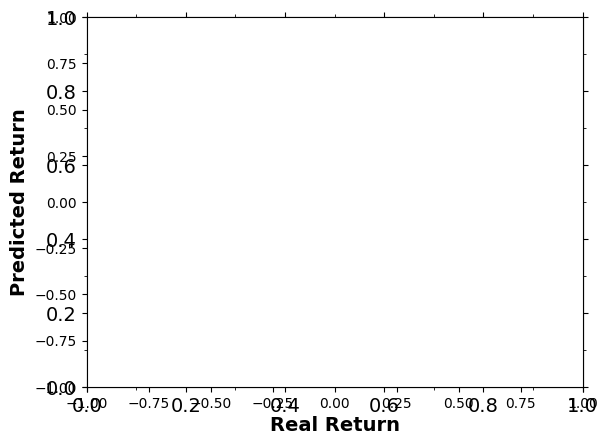

In [24]:
import matplotlib.ticker as ticker
#figure for both training and testing data
#plt.figure(figsize=(4,3.5))
# if standardization
plt.scatter(y_train_reform[:,0], y_train_pred_LSTM_reform[:,0], alpha=0.3, facecolors='none', edgecolors='r',label='Train')
plt.scatter(y_test_reform[:,0], y_test_pred_LSTM_reform[:,0], alpha=0.3, facecolors='none', edgecolors='b',label='Test')

plt.legend()


plt.xlabel('Real Return', fontsize=14, weight='bold')
plt.ylabel('Predicted Return', fontsize=14, weight='bold')
plt.plot([-10, 10], [-10, 10], alpha=0.5, color = 'black')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.annotate(("R2_train = {:.3f}".format(R2_train)),(6,3))
plt.annotate(("R2_test = {:.3f}".format(R2_test)),(6,2))
#ax = plt.axes()
#ax.tick_params(axis='both', which='both', labelsize=14, bottom=True, top=True, left=True, right=True)
#ax.xaxis.set_major_locator(plt.MaxNLocator(6))
#ax.yaxis.set_major_locator(plt.MaxNLocator(6))
#ax.xaxis.set_minor_locator(plt.MaxNLocator(12))
#ax.yaxis.set_minor_locator(plt.MaxNLocator(12))
#ax.set_title('R2: ' + str('R2_train: ' + str(R2_train)))
#ax.annotate(("r-squared = {:.3f}".format(R2_train)), (0, 1))
plt.show()

In [22]:
np.savetxt("y_train_pred_LSTM_reform.csv", y_train_pred_LSTM_reform, delimiter=",")
np.savetxt("y_train_reform.csv", y_train_reform, delimiter=",")

### Predict for Later Optimization

In [21]:
raw = np.loadtxt(open("prices_final.csv","rb"), delimiter=",")
#X_final = np.concatenate((raw[:,0].reshape(20,1), raw[:,(raw.shape[1]-30):]), axis=1)
X_final = raw[:,(raw.shape[1]-30):].reshape(X_final.shape[0], X_final.shape[1], 1)
X_final = torch.tensor(X_final)
print(X_final.shape)

torch.Size([20, 30, 1])


In [25]:
y_final = LSTM.predict(X_final).squeeze(-1)
y_final = y_final.cpu().detach().numpy()
y_final = y_final[:,0]*std_y[0] + mu_y[0]

In [26]:
np.savetxt("Return_mean.csv", y_final, delimiter=',')

### Predict for Benchmark Time Series

In [31]:
prices_final = np.loadtxt(open("prices_final.csv","rb"), delimiter=",")
return_final = np.loadtxt(open("return_final.csv","rb"), delimiter=",")

In [34]:
print(mu_X.T.shape)

(1, 30)


In [45]:
y_BMpred = np.zeros((20,30))
for i in range(30):
    X_BM = prices_final[:, (31+i):(31+i+30)]
    X_BM = (X_BM - mu_X.T) / (std_X.T)
    X_BM = X_BM.reshape(X_BM.shape[0], X_BM.shape[1], 1)
    X_BM = torch.tensor(X_BM)
    y_BMpred_i = LSTM.predict(X_BM).squeeze(-1)
    y_BMpred_i = y_BMpred_i.cpu().detach().numpy()
    y_BMpred_i = y_BMpred_i[:,0]*std_y[0] + mu_y[0]
    y_BMpred[:,i] = y_BMpred_i
    
print(y_BMpred.shape)

(20, 30)


 /home/jupyter/YD/Optimization/Models.py:62: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [46]:
np.savetxt("Return_mean_LSTM.csv", y_BMpred, delimiter=',')